In [158]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os

import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Module
from torch.optim import Optimizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

Let us start simply by loading the data and dropping irrelevant or duplicate collumns

In [90]:
pd.set_option('display.max_columns', None)
df_all_merged = pd.read_csv('data/Data_merged_temp_features.csv')
df_all_merged.head()

,Unnamed: 0,org_uuid,org_name,domain,status,founded_on,category_list,category_groups_list,country_code,city,short_description,earliest_funding,time_first_funding,time_first_funding_normalised,seed_funding,seed_funding_log,seed_funding_normalised,series_a_funding_date,time_till_series_a,time_till_series_a_normalised,series_a_funding,series_a_funding_log,series_a_funding_normalised,seed_n_rounds,series_a_n_rounds,angel_n_rounds,pre_seed_n_rounds,success_flag
0,0,86bd89a7-fe3f-12d4-817c-8157c8592194,i.Sec,isec.ng,operating,2013-01-01,"Finance,FinTech",Financial Services,NGA,Lagos,i.Sec is a financial security service that all...,NaN,NaN,0.422449,0.0,0.000000,0.000000,NaN,NaN,0.313231,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0
1,1,58fd74f2-9ebb-4a41-cd75-05f9214a9a11,Kukua,kukua.me,operating,2015-01-01,"Content,EdTech,Franchise,Media and Entertainment","Education,Media and Entertainment,Other,Software",KEN,Nairobi,The edutainment company for children of the 21...,2018-11-08,1407 days,0.414477,2500961.0,6.398107,0.250096,2022-06-29,2736 days,0.633406,6000000.0,6.778151,0.600000,3.0,1.0,0.0,0.0,0
2,2,e8772824-d8d5-7636-0bd5-40b76511213b,Airdog,airdog.com,operating,2014-01-01,"Artificial Intelligence,Drones,Robotics","Artificial Intelligence,Consumer Electronics,C...",LVA,Riga,We build smart robots that bring unprecedented...,2015-03-19,442 days,0.242002,2499329.0,6.397823,0.249933,2016-07-18,929 days,0.238865,3506665.0,6.544894,0.350666,1.0,1.0,0.0,0.0,0
3,3,be72d0fa-b5b0-eb2d-f8aa-3cb290f97b33,Ubiq.ai,ubiq.ai,operating,2015-01-01,"Autonomous Vehicles,Car Sharing,Internet,Last ...","Internet Services,Real Estate,Software,Transpo...",AUT,Vienna,Ubiq is shaping the future of urban mobility b...,2015-04-09,98 days,0.180518,1440559.0,6.158531,0.144056,NaN,NaN,0.418952,0.0,0.000000,0.000000,1.0,0.0,0.0,1.0,0
4,4,7c9e6d25-8cf0-80a5-dfd6-d1a21337534d,ANKA,anka.africa,operating,2016-01-01,"Art,E-Commerce,Fashion,Handmade","Clothing and Apparel,Commerce and Shopping,Con...",CIV,Abidjan,"ANKA is a platform to discover, buy, and sell ...",2017-06-21,537 days,0.258981,8076881.0,6.907244,0.807688,NaN,NaN,0.520437,0.0,0.000000,0.000000,5.0,0.0,0.0,1.0,0


In [91]:
drop_col_list = ['earliest_funding', 
                 'domain', 
                 'org_uuid',
                 'country_code',
                 'series_a_funding_log',
                 'org_name',
                 'seed_funding_log',
                 'series_a_funding', 
                 'city', 
                 'short_description', 
                 'founded_on', 
                 'category_list', 
                 'seed_funding', 
                 'time_first_funding', 
                 'status', 
                 'Unnamed: 0', 
                 'time_till_series_a', 
                 'category_groups_list', 
                 'series_a_funding_date']


df_all_clean = df_all_merged.drop(labels = drop_col_list, axis=1)


In [92]:
df_all_clean.head()

,time_first_funding_normalised,seed_funding_normalised,time_till_series_a_normalised,series_a_funding_normalised,seed_n_rounds,series_a_n_rounds,angel_n_rounds,pre_seed_n_rounds,success_flag
0,0.422449,0.000000,0.313231,0.000000,0.0,0.0,0.0,0.0,0
1,0.414477,0.250096,0.633406,0.600000,3.0,1.0,0.0,0.0,0
2,0.242002,0.249933,0.238865,0.350666,1.0,1.0,0.0,0.0,0
3,0.180518,0.144056,0.418952,0.000000,1.0,0.0,0.0,1.0,0
4,0.258981,0.807688,0.520437,0.000000,5.0,0.0,0.0,1.0,0


Lets start modelling, we will start of with logistic regression, and L1/L2 regularisation variants.

In [93]:
# data
y = df_all_clean.pop('success_flag').to_frame()
X = df_all_clean

In [105]:
# train/test split and 

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

log_reg_model_vanilla = LogisticRegression(random_state=0, penalty='none')
log_reg_model_vanilla.fit(X_train, y_train)
mean_acc = log_reg_model_vanilla.score(X_test, y_test)
print("mean accuracy of vanilla logistic regression is: " + str(mean_acc))

mean accuracy of vanilla logistic regression is: 0.9555921052631579


Now we can try L1 regularisation

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

log_reg_model_l1 = LogisticRegression(random_state=0, penalty='l1', solver='saga')
log_reg_model_l1.fit(X_train, y_train)
mean_acc = log_reg_model_l1.score(X_test, y_test)
print("mean accuracy of l1 logistic regression is: " + str(mean_acc))

mean accuracy of l1 logistic regression is: 0.9580592105263158


/Users/jrubruck/opt/anaconda3/envs/VelaMoneyball/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Now we can try L2 regularisation

In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

log_reg_model_l2 = LogisticRegression(random_state=0, penalty='l2')
log_reg_model_l2.fit(X_train, y_train)
mean_acc = log_reg_model_l2.score(X_test, y_test)
print("mean accuracy of l2 logistic regression is: " + str(mean_acc))

mean accuracy of l2 logistic regression is: 0.9481907894736842


Okay, so regularisation does not seem to make a huge difference in this dataset. Given the quite large number of datapoints we should perhaps not expect the model to be prone to overfitting. Let's make some ROC curves for this

In [140]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs_vanilla = log_reg_model_vanilla.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_vanilla = lr_probs_vanilla[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc_vanilla = roc_auc_score(y_test, lr_probs_vanilla)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc_vanilla))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs_vanilla)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.975


Text(0.5, 1.0, 'ROC Curve Vanilla Logisitc Regression')

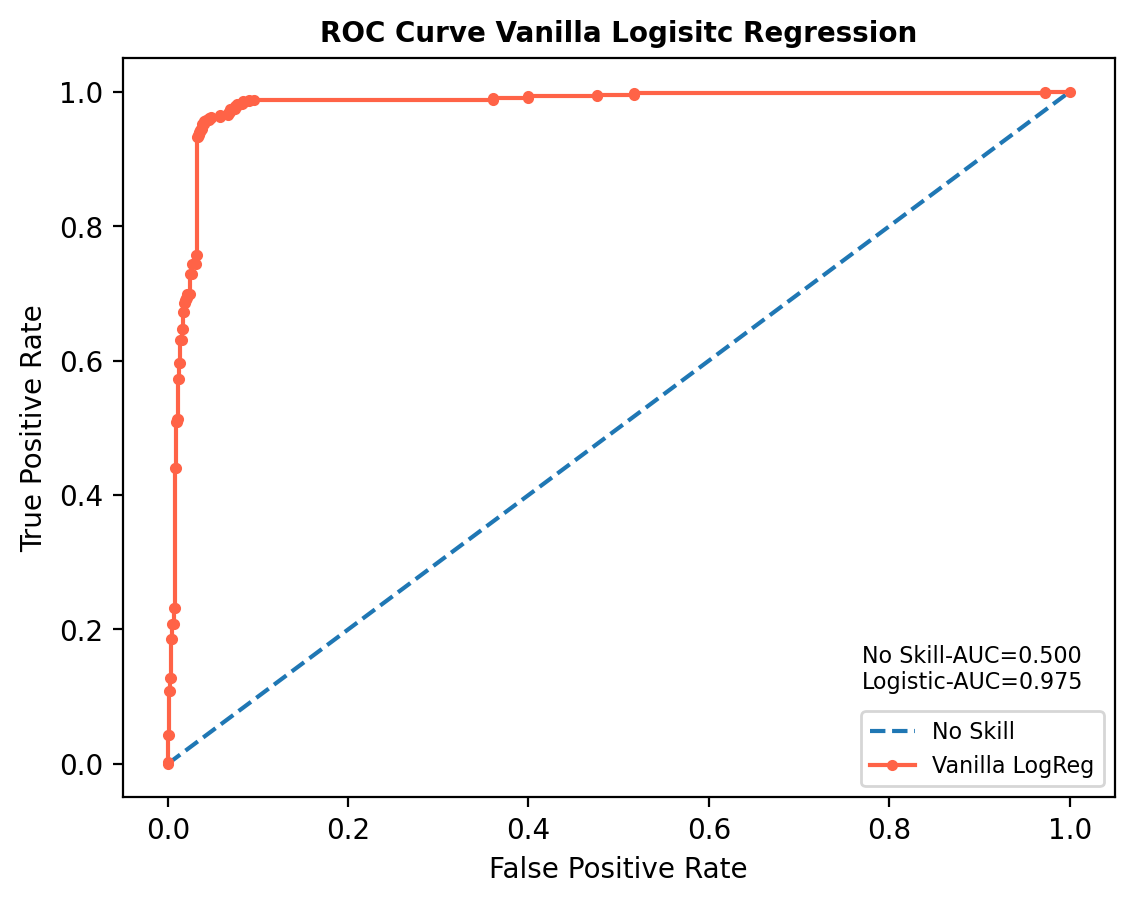

In [142]:
# Lets plot this

fig, ax = plt.subplots(dpi=200, facecolor='w')
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax.plot(lr_fpr, lr_tpr, marker='.', label='Vanilla LogReg', color='tomato')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(fontsize=8)
# make a second legend with mean, median, and sd
ax.annotate('No Skill-AUC=%.3f\nLogistic-AUC=%.3f' % (ns_auc, lr_auc_vanilla), 
            xy=(.745, .14), 
            xycoords='axes fraction', 
            fontsize=8,
            horizontalalignment='left', 
            verticalalignment='bottom')
ax.set_title('ROC Curve Vanilla Logisitc Regression', fontsize=10, fontweight='bold')

In [146]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs_l1 = log_reg_model_l1.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_l1 = lr_probs_l1[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc_l1 = roc_auc_score(y_test, lr_probs_l1)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc_l1))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs_l1)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.978


Text(0.5, 1.0, 'ROC Curve L1 Logisitc Regression')

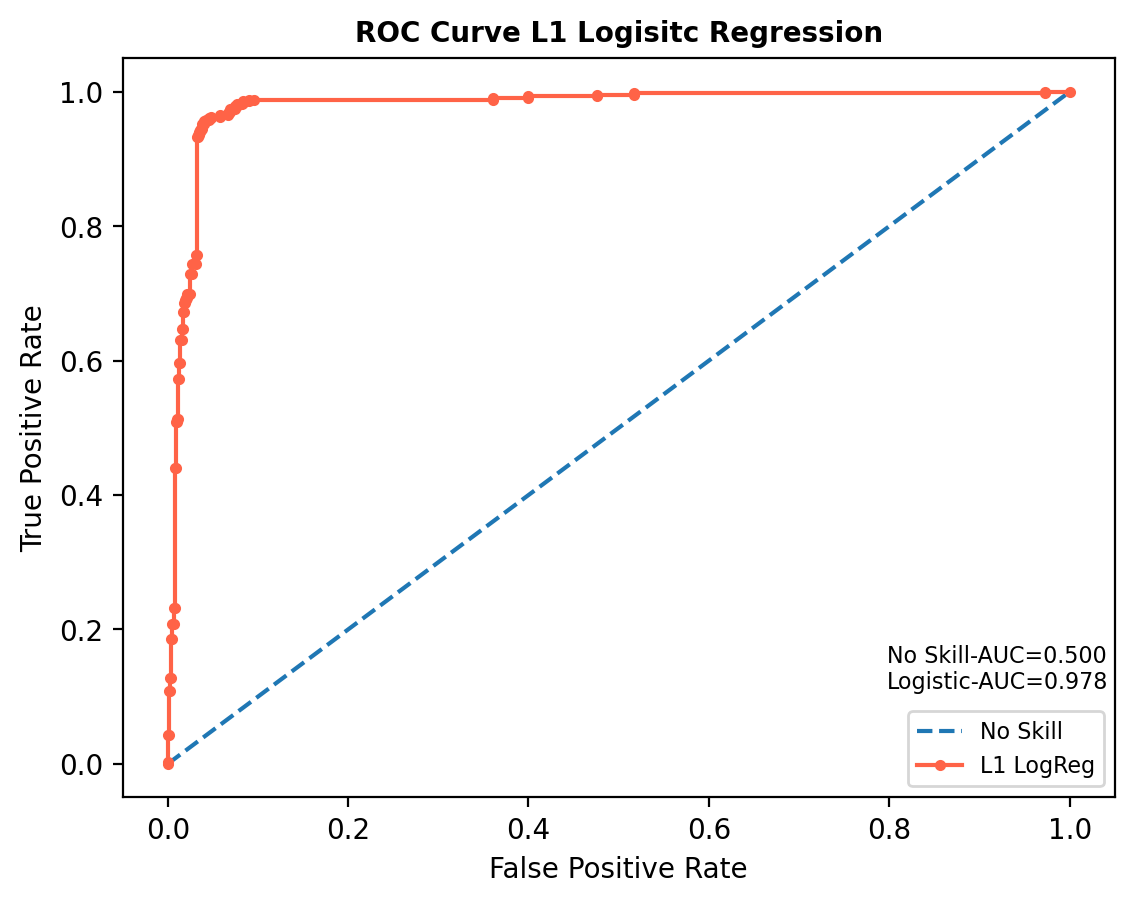

In [147]:
# Lets plot this

fig, ax = plt.subplots(dpi=200, facecolor='w')
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax.plot(lr_fpr, lr_tpr, marker='.', label='L1 LogReg', color='tomato')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(fontsize=8)
# make a second legend with mean, median, and sd
ax.annotate('No Skill-AUC=%.3f\nLogistic-AUC=%.3f' % (ns_auc, lr_auc_l1), 
            xy=(.77, .14), 
            xycoords='axes fraction', 
            fontsize=8,
            horizontalalignment='left', 
            verticalalignment='bottom')
ax.set_title('ROC Curve L1 Logisitc Regression', fontsize=10, fontweight='bold')

In [148]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs_l2 = log_reg_model_l2.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs_l2 = lr_probs_l2[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc_l2 = roc_auc_score(y_test, lr_probs_l2)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc_l2))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs_l2)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.974


Text(0.5, 1.0, 'ROC Curve L2 Logisitc Regression')

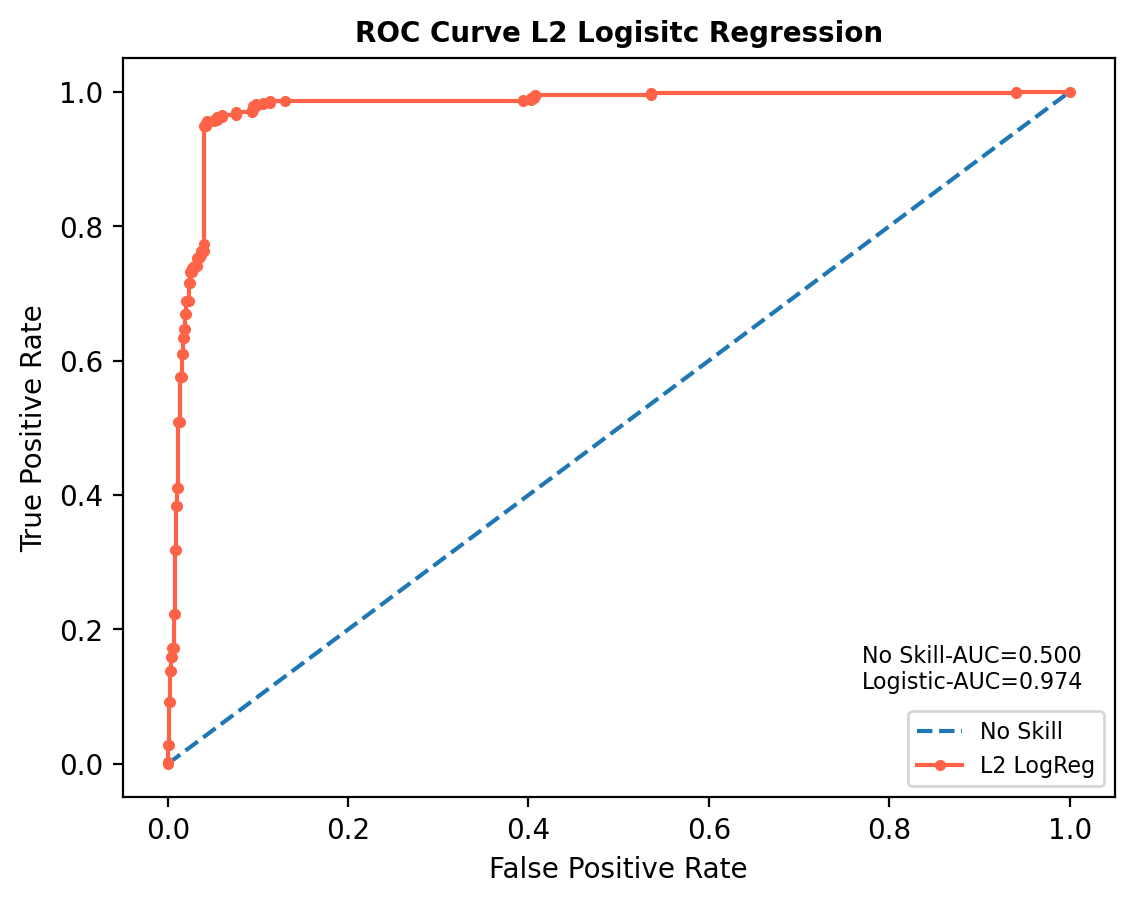

In [149]:
# Lets plot this

fig, ax = plt.subplots(dpi=200, facecolor='w')
ax.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax.plot(lr_fpr, lr_tpr, marker='.', label='L2 LogReg', color='tomato')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(fontsize=8)
# make a second legend with mean, median, and sd
ax.annotate('No Skill-AUC=%.3f\nLogistic-AUC=%.3f' % (ns_auc, lr_auc_l2), 
            xy=(.745, .14), 
            xycoords='axes fraction', 
            fontsize=8,
            horizontalalignment='left', 
            verticalalignment='bottom')
ax.set_title('ROC Curve L2 Logisitc Regression', fontsize=10, fontweight='bold')

These are all quite similar, lets make a confusion matrix to get a better idea of Truepositive ratio etc.

In [152]:
y_pred = log_reg_model_vanilla.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 1.0, 'Confusion matrix of Vanilla Logisitc Regression')

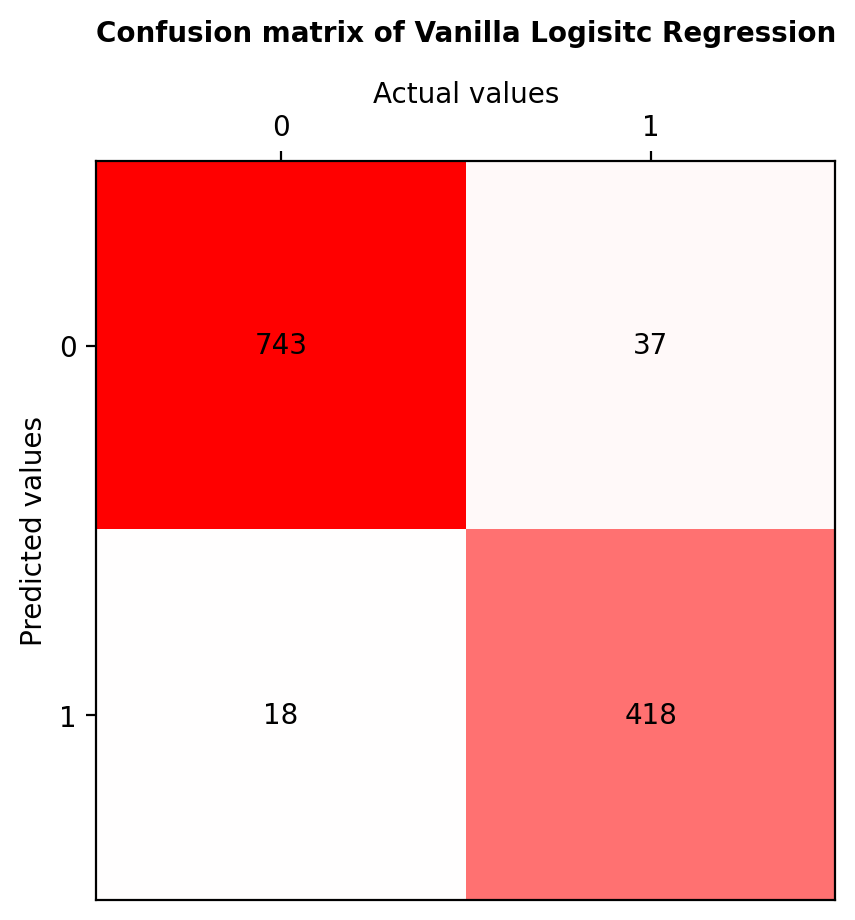

In [171]:
# Lets plot this
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

fig, ax = plt.subplots(dpi=200, facecolor='w')
cmap = plt.get_cmap('bwr')
new_cmap = truncate_colormap(cmap, 0.5, 1)

ax.matshow(cm, cmap=new_cmap)
ax.xaxis.set_label_position('top')
ax.set_xlabel('Actual values')
ax.set_ylabel('Predicted values')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False)

ax.set_xticks([0,1])
ax.set_xticklabels(['0','1'])

for i in range(2):
    for j in range(2):
        c = cm[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

# # make a second legend with mean, median, and sd
# ax.annotate('No Skill-AUC=%.3f\nLogistic-AUC=%.3f' % (ns_auc, lr_auc_l2), 
#             xy=(.745, .14), 
#             xycoords='axes fraction', 
#             fontsize=8,
#             horizontalalignment='left', 
#             verticalalignment='bottom')

ax.set_title('Confusion matrix of Vanilla Logisitc Regression', fontsize=10, fontweight='bold', pad=14)

Make a new plot for with tpr, fnr, tnr, fpr

In [ ]:
cm_normalised = np.sum()